In [1]:
import requests
import json
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class GitHubRepository:
    def __init__(self, name, owner,  description, homepage, license, forks, watchers, date_of_collection):
        self.name = name
        self.owner = owner
        self.description = description
        self.homepage = homepage
        self.license = license  # License could be another class with its own attributes
        self.forks = forks
        self.watchers = watchers
        self.date_of_collection = date_of_collection

        #placeholder
        self.pull_requests = None
        self.contributors = 0

    @staticmethod
    def parse(dict):
        name = dict['name'] if 'name' in dict else None
        owner = dict['owner']['login'] if 'owner' in dict and 'login' in dict['owner'] else None
        description = dict['description'] if 'description' in dict else None
        homepage = dict['homepage'] if 'homepage' in dict else None
        forks = dict['forks'] if 'forks' in dict else None
        watchers = dict['watchers'] if 'watchers' in dict else None
        license = dict['license']['name'] if 'license' in dict and dict['license'] != None and 'name' in dict['license'] else None

        #get current time in UTC

        time = datetime.now()
        formatted_time = time.strftime("%Y-%m-%dT%H:%M:%SZ")

        return GitHubRepository(name, owner, description, homepage, license, forks, watchers, formatted_time)

    def set_pull_requests(self, pull_requests):
      self.pull_requests = pull_requests

    def set_contributors(self, count):
      self.contributors = count

    def __str__(self):
        return f'{self.owner}/{self.name}: license = [{self.license}], homepage = [{self.homepage}], forks = ({self.forks}), watchers = ({self.watchers}), date of collection: {self.date_of_collection} \nDescription:\n"{self.description}"'

    def save_as_csv(self):
      try:
        with open('repositories.csv','a') as file:
          file.write(str(self))
          file.write('\n')
      except Error:
        print('Error while writing in file')

In [3]:
class PullRequest:
    def __init__(self,user, title, number, body, state, created_at, closed_at):
        self.user = user
        self.title = title
        self.number = number
        self.body = body
        self.state = state
        self.created_at = created_at
        self.closed_at = closed_at
        self.pr_status = None

    def get_creation_day_month_year(self):
      created_date = datetime.strptime(self.created_at, '%Y-%m-%dT%H:%M:%SZ')
      return (created_date.day, created_date.month, created_date.year)

    def set_status(self, pr_status):
      self.pr_status = pr_status

    def save_as_csv(self, owner,repo_name):
        with open(f'repos/{owner}/{repo_name}','a') as file:
          file.write(str(self))
          file.write('\n')

    @staticmethod
    def parse(dict):
        title = dict['title'] if 'title' in dict else None
        user = dict['user']['login'] if 'user' in dict and 'login' in dict['user'] else None
        number = dict['number'] if 'number' in dict else None
        body = dict['body'] if 'body' in dict else None
        state = dict['state'] if 'state' in dict else None
        created_at = dict['created_at'] if 'created_at' in dict else None
        closed_at = dict['closed_at'] if 'closed_at' in dict else None

        return PullRequest(user,title,number,body,state,created_at,closed_at)

    def __str__(self):
        return f"{self.user}/{self.title}: ({self.state}) ({self.number}) ({self.created_at}) ({self.closed_at})"

In [4]:
class PRStatus:
    def __init__(self,number,commits,additions,deletions,changed_files):
        self.number = number
        self.commits = commits
        self.additions = additions
        self.deletions = deletions
        self.changed_files = changed_files

    @staticmethod
    def parse(dict):
        number = dict['number'] if 'number' in dict else None
        commits = dict['commits'] if 'commits' in dict else None
        additions = dict['additions'] if 'additions' in dict else None
        deletions = dict['deletions'] if 'deletions' in dict else None
        changed_files = dict['changed_files'] if 'changed_files' in dict else None

        return PRStatus(number,commits,additions,deletions,changed_files)

    def __str__(self):
        return f"PullRequest #{self.number}: commits = ({self.commits}) additions = ({self.additions}) deletions = ({self.deletions}) file changes = ({self.changed_files})"

In [5]:
class UserInfo:
    def __init__(self, name, no_of_repos, followers, following):
        self.name = name
        self.no_of_repos = no_of_repos
        self.followers = followers
        self.following = following

    @staticmethod
    def parse(dict):
        name = dict['name'] if 'name' in dict else None
        no_of_repos = dict['public_repos'] if 'public_repos' in dict else None
        followers = dict['followers'] if 'followers' in dict else None
        following = dict['following'] if 'following' in dict else None

        return UserInfo(name, no_of_repos, followers, following)

    def set_contributions(self,contributions):
        self.contributions = contributions

    def __str__(self):
        return f'{self.name}: public repositories = {self.no_of_repos}, followers = {self.followers}, following = {self.following}, contributions in last year = {self.contributions}'

    def save_as_csv(self):
          with open('users.csv','a') as file:
            file.write(str(self))
            file.write('\n')

In [6]:
# Get Repository

owner = "debsourav33"
repo_name = "Leetcode-Solutions"

def get_repository(owner, repo) -> GitHubRepository :

    url = f"https://api.github.com/repos/{owner}/{repo}"
    response = requests.get(url)

    if response.status_code != 200:
        print(f'Status code {response.status_code} while trying to fetch repository {owner}/{repo}')
        return None

    resp_dict = response.json()
    pretty_response = json.dumps(resp_dict, indent = 4)
    #print(pretty_response)

    ret = GitHubRepository.parse(resp_dict)

    users_url = f"https://api.github.com/repos/{owner}/{repo}/contributors"
    users_resp = requests.get(users_url)
    if users_resp.status_code == 200:
      users = len(users_resp.json())
      ret.set_contributors(users)
      #print(f'{users} users in repo {repo}')
      #print(users_resp.json())

    return ret

#github_repo = get_repository('ramnes', 'notion-sdk-py')
#print(github_repo)
# github_repo.save_as_csv()

In [7]:
# Get Pull Request
def getPullRequests(owner, repo):
    url = f"https://api.github.com/repos/{owner}/{repo}/pulls"
    #print(url)
    response = requests.get(url)

    if response.status_code != 200:
        print(f'Status code {response.status_code} while trying to fetch PRs for repository {owner}/{repo}')
        return None
    else:
        resp_list = response.json()
    #print(len(resp_list))
    ret = []
    for item in resp_list:
        pr= PullRequest.parse(item)
        ret.append(pr)
        #print(pr)
    return ret


def getPullRequestInfo(owner, repo, number):
    url = f"https://api.github.com/repos/{owner}/{repo}/pulls/{number}"
    response = requests.get(url)

    if response.status_code != 200:
        print(f"Failed to retrieve pull request info. Status code: {response.status_code}")
        return None
    else:
        resp_dict = response.json()
        #print(type(resp_dict))
        #print(resp_dict)
        pr_info = PRStatus.parse(resp_dict)
        #print(pr_info)
        return pr_info



owner = "python"
repo = "mypy"

def get_pr_with_status(owner, repo, limit = 10):

  pull_requests = getPullRequests(owner,repo)
  pr_status = []

  if pull_requests != None:
    for i in range(min(limit,len(pull_requests))):
        pr = pull_requests[i]

        if pr.number != None:
            pr_info = getPullRequestInfo(owner, repo, pr.number)
            pr_status.append(pr_info)

            pr.set_status(pr_info)
    return pull_requests[:limit]

#pull_requests, pr_status = get_pr_with_status(owner, repo)

In [8]:
# @title
# Graphs and Plots

def visualize(repo_name, states, commits, additions, deletions, changed_files, users):

  try:
    #for simulating closed PRs
    states[0] = 'closed'
    states[1] = 'closed'

    #common features
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))


    # A boxplot that compares closed vs. open pull requests in terms of number of commits

    commits_dict = {'commits':commits, 'states':states}
    df = pd.DataFrame(commits_dict)
    bplot = df.boxplot(by='states',column = 'commits', ax=axes[0, 0], grid = False)
    bplot.plot()

    axes[0, 0].set_title('closed vs. open pull requests for number of commits')

    # A boxplot that compares closed vs. open pull requests in terms of additions

    commits_dict = {'additions':additions, 'states':states}
    df = pd.DataFrame(commits_dict)
    bplot = df.boxplot(by='states',column = 'additions', ax=axes[0, 1], grid = False)
    bplot.plot()

    axes[0, 1].set_title('closed vs. open pull requests for number of  additions')


    # A boxplot that compares closed vs. open pull requests in terms of deletions

    commits_dict = {'deletions':deletions, 'states':states}
    df = pd.DataFrame(commits_dict)
    bplot = df.boxplot(by='states',column = 'deletions', ax=axes[1, 0], grid = False)
    bplot.plot()

    axes[1, 0].set_title('closed vs. open pull requests for number of  deletions')


    # A boxplot that compares the number of changed files grouped by the author association


    map = {'user':users, 'file_changes':changed_files}
    df = pd.DataFrame(map)
    bplot = df.boxplot(by='user',column='file_changes', ax=axes[1, 1], rot = 60)
    bplot.plot()


    axes[1, 1].set_title('number of changed files grouped by the author association')

    #A scatterplot that shows the relationship between additions and deletions
    map = {'additions': additions, 'deletions': deletions}
    df = pd.DataFrame(map)

    ax = df.plot.scatter(x='additions', y='deletions', alpha=0.5, ax=axes[2, 0])

    axes[2, 0].set_title('relationship between additions and deletions per pull_requests')

    #blank 6th plot
    axes[2, 1].axis('off')

    fig.suptitle(f'Data Visualization for Repository "{repo_name}"', fontsize=16)

    plt.tight_layout()

    plt.show()

  except Error:
    print('Error occured during graph plotting')

def plot_graphs(repo, pull_requests, pr_status, limit = -1):
  #limit = min(len(pull_requests), 10) #so that we don't reach api call limit
  #limit = -1
  #pull_requests, pr_status = check_pr(limit)

  if limit == -1:
    limit = len(pr_status)

  states = [pr.state for pr in pull_requests[:limit]]
  commits = [pr.commits for pr in pr_status[:limit]]
  additions = [pr.additions for pr in pr_status[:limit]]
  deletions = [pr.deletions for pr in pr_status[:limit]]
  users = [pr.user for pr in pull_requests[:limit]]
  changed_files = [pr.changed_files for pr in pr_status[:limit]]

  visualize(repo, states, commits, additions, deletions, changed_files, users)

#check_graphs()

In [9]:
from copy import Error
# @title
def visualize_all_repo(pull_requests, pr_status, repos):
  try:
    pr_per_day = {}
    open_pr_per_day = {}
    closed_pr_per_day = {}

    for i in range(len(pull_requests)):
      pr = pull_requests[i]
      status = pr_status[i]

      date =  pr.get_creation_day_month_year()


      pr_per_day[date] = pr_per_day.get(date,0) + 1

      if status == 'open':
        open_pr_per_day[date] = open_pr_per_day.get(date,0) + 1
      else:
        closed_pr_per_day[date] = closed_pr_per_day.get(date,0) + 1

    #A line graph showing the total number of pull requests per day
    df = pd.DataFrame(data= list(pr_per_day.items()), columns=['date','pull_requests'])
    df = df.set_index('date')
    print(df)
    df.plot(kind='line', marker='o')

    #A line graph comparing number of open and closed pull requests per day
    df_open = pd.DataFrame(data= list(open_pr_per_day.items()), columns=['date','pull_requests'])
    df_closed = pd.DataFrame(data= list(closed_pr_per_day.items()), columns=['date','pull_requests'])
    df_merged = pd.merge(df_open, df_closed, on='date', how='outer').fillna(0)

    # Set 'date' column as the index
    df_merged = df_merged.set_index('date')
    df_merged.plot(kind='line', marker='o')
    plt.legend(['Open PRs', 'Closed PRs'])


    # A bars plot comparing the number of users per repository
    data = {
    'Repository': [r.name for r in repos],
    'UserCount': [r.contributors for r in repos]
    }

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Plot the data
    df.plot(kind='bar', x='Repository', y='UserCount', legend=False, color='blue')

    plt.xlabel('Repositories')
    plt.ylabel('Number of Users')
    plt.title('Number of Users per Repository')

    plt.show()

  except Error:
    print('Error occured during graph plotting')


#visualize_all_repo(pull_requests[:limit], pr_status[:limit])

In [10]:
# @title
# Get User Info

user = "jabref"


def getUserInfo(user):
    url = f'https://api.github.com/users/{user}'

    user_info = None

    response = requests.get(url)

    if response.status_code != 200:
        print(f"Status code for fetching user info from {url}: {response.status_code}")
        return None
    else:
        resp_dict = response.json()
        user_info = UserInfo.parse(resp_dict)
            #print(json.dumps(resp_dict,indent = 4))

        #contributions
        url = f"https://api.github.com/users/{user}/events"
        response = requests.get(url)

    events = []
    if response.status_code != 200:
        #print(f"Status code for {url}: {response.status_code}")
        pass
    else:
        events = response.json()
    contributions = 0

    for event in events:
        if event.get('type','null') == 'PushEvent':
        #print(json.dumps(event, indent=4))

        #check if the contribution was made this year
          created_at = event.get('created_at','')
          if created_at != '':
              created_year = datetime.strptime(created_at, '%Y-%m-%dT%H:%M:%SZ').year
              curr_year = datetime.now().year

          if curr_year == created_year:
              contributions += 1


    if user_info != None:
        user_info.set_contributions(contributions)

    return user_info

#user_info = getUserInfo(user)
#print(user_info)

In [11]:
def get_repo():
  repo_name = input('Enter the repository name: ').lower()
  owner = input('Enter the owner name: ').lower()

  repository = get_repository(owner, repo_name)

  if repository == None:
    print('No such repository found! Please check the repo and owner name (And also if you have reached API limit).')
  else:
    prs = get_pr_with_status(owner, repo_name,)
    repository.set_pull_requests(prs)
    repository.save_as_csv()

    print('')
    print('Repository found!')
    print(repository)
    print('')

  return repository

def show_collected_repos(repos):
  print(f'Total {len(repos)} repositories collected so far')

  cnt = 1

  print()
  for repo in repos:
    print(f'{cnt}. {repo.name}')
    cnt += 1
  print()

def show_pull_requests(repo):
  pull_requests = repo.pull_requests
  if pull_requests != None:
    count = len(pull_requests)
    print('')
    print(f'{count} pull requests are associated with this repository')
    print('')

    for pr in pull_requests:
      print('')
      print(f'PR #{pr.number} created by user: {pr.user}')
      print(pr)
      print('')
  else:
    print('No pull requests found (This can happen if API limit is exceeded)')

def show_summary(repo):
  print('')
  print(repo)
  print('')

  open_prs = 0
  closed_prs = 0
  users = 0 if repo.contributors == None else repo.contributors

  prs = repo.pull_requests

  if prs != None:
    for pr in prs:
      if pr.state == 'open':
        open_prs += 1
      else:
        closed_prs += 1

  print(f'No of users: {users}, Open Pull Requests: {open_prs}, Closed Pull Requests: {closed_prs}')



def show_repo_visual(repo):
  prs = repo.pull_requests

  if prs == None or len(prs) == None:
    print('No pull requests found to plot graphs for (This can happen if API limit is exceeded)')
    return

  status = [pr.pr_status for pr in prs]

  for st in status:
    if st == None:
      print('Cannot fetch all the pull request info (This can happen if API limit is exceeded)')
      return

  plot_graphs(repo.name, prs, status)

def show_all_repo_visual(repos):
  prs = []
  status = []
  for repo in repos:
    if repo.pull_requests == None:
      continue

    for pr in repo.pull_requests:
      if pr.pr_status == None:
        continue;

      prs.append(pr)
      status.append(pr.pr_status)

  if len(repos) == 0:
    print('No repo collected')
  elif len(prs) == 0:
    print('No pull requests found to plot graphs for (This can happen if API limit is exceeded)')
  else:
    visualize_all_repo(prs,status, repos)


def show_correlation_for_users(repos):
  user_names = []
  for repo in repos:
    for pr in repo.pull_requests:
      if pr != None and pr.user != None:
        user_names.append(pr.user)

  limit = min(len(user_names),5)
  users = [getUserInfo(name) for name in user_names]

  if users == None or len(users) == 0:
    print('No user found')
    return

  data = {
      'followers' : [user.followers if user != None else 0 for user in users],
      'following' : [user.following  if user != None else 0 for user in users],
      'public_repos' : [user.no_of_repos  if user != None else 0 for user in users],
      'contribution' : [user.contributions if user != None else 0 for user in users],
  }

  df = pd.DataFrame(data)
  correlation_matrix = df.corr()

  # Print or use the correlation matrix as needed
  print()
  print('Correlation Matrix')
  print(correlation_matrix)
  print()

  try:
    sns.heatmap(correlation_matrix , annot=True, cmap="coolwarm")
    plt.title(f"PR Correlation plot for {repo.owner}/{repo.name}")
    plt.show()
  except Error:
    print('Error in generating heatmap')





1. Get repository
2. Show Collected Repositories
3. Show visual representation for all repositories
4. Calculate correlation among the stored users data
0. Exit

Enter your option: 4
No user found

1. Get repository
2. Show Collected Repositories
3. Show visual representation for all repositories
4. Calculate correlation among the stored users data
0. Exit

Enter your option: 1
Enter the repository name: jabref
Enter the owner name: jabref

Repository found!
JabRef/jabref: license = [MIT License], homepage = [https://devdocs.jabref.org], forks = (2269), watchers = (3213), date of collection: 2023-12-02T04:04:22Z 
Description:
"Graphical Java application for managing BibTeX and biblatex (.bib) databases"


1. Get repository
2. Show Collected Repositories
3. Show visual representation for all repositories
4. Calculate correlation among the stored users data
0. Exit

Enter your option: 4

Correlation Matrix
              followers  following  public_repos  contribution
followers      1.0

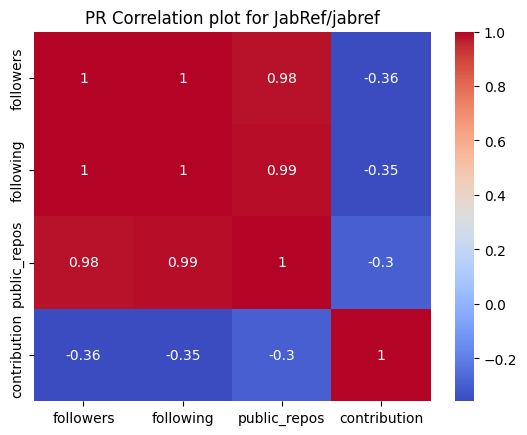


1. Get repository
2. Show Collected Repositories
3. Show visual representation for all repositories
4. Calculate correlation among the stored users data
0. Exit

Enter your option: 0


In [12]:
def show_menu():
  main_menu = (
      "1. Get repository",
      "2. Show Collected Repositories",
      "3. Show visual representation for all repositories",
      "4. Calculate correlation among the stored users data",
      "0. Exit",
  )

  print('')
  for opt in main_menu:
    print(opt)
  print('')

def show_sub_menu():
  repo_submenu = (
      "1. Show summary",
      "2. Show all pull requests",
      "3. Show visual representation of the repository",
      "4. Calculate correlation for all  data in the repository",
      "0. Return to main menu",
  )

  print()
  for opt in repo_submenu:
    print('\t'+opt)
  print()


def get_option(st, endi, sub_menu = False):
  opt = -1
  opted = False

  while not opted:

    if not sub_menu:
      show_menu()
    else:
      show_sub_menu()

    try:
      opt = int(input('Enter your option: '))

      if opt<st or opt>endi:
        print('Option must be between {st} and {endi}')
      else:
        opted = True

    except ValueError:
      print('Option must be an integer')

  return opt

def choose_repo(cnt):
  opt = -1
  opted = False

  while not opted:
    try:

      opt = int(input('Enter the repository no. you want to browse or 0 to quit: '))

      if opt<0 or opt>cnt:
        print(f'Must provide a no. between 0 and {cnt}')
      else:
        opted = True

    except ValueError:
      print('Option must be an integer')

  return opt


def handle_sub_opt(repo , opt):
  if opt == 1:
    show_summary(repo)
  if opt == 2:
    show_pull_requests(repo)
  if opt == 3:
    show_repo_visual(repo)
  pass

def main():
  repos = []
  opt = -1

  while opt != 0:
    opt = get_option(0,5)

    if opt == 1:
      repo = get_repo()
      if repo != None:
        repos.append(repo)

    if opt == 3:
      show_all_repo_visual(repos)

    if opt == 4:
      show_correlation_for_users(repos)

    if opt == 2:
      show_collected_repos(repos)
      if len(repos) == 0:
        continue

      repo_no = choose_repo(len(repos))
      if repo_no == 0:
        continue

      repo = repos[repo_no-1]
      print(repo.name)
      opt2 = get_option(0,5, sub_menu= True)
      while opt2 != 0:
        handle_sub_opt(repo,opt2)
        print(repo.name)
        opt2 = get_option(0,5, sub_menu= True)

main()


In [13]:
# @title
# import the unittest module
import unittest
from datetime import datetime

# create a test class that inherits from unittest.TestCase
class TestGitHubRepository(unittest.TestCase):

    # use the setUp method to perform any setup actions before each test
    def setUp(self):
        # create a sample dictionary to use as input for the parse method
        self.sample_dict = {
            "name": "python-testing",
            "owner": {
                "login": "realpython"
            },
            "description": "A tutorial on testing in Python",
            "homepage": "https://realpython.com/python-testing/",
            "license": {
                "name": "MIT License"
            },
            "forks": 42,
            "watchers": 100
        }

    # write test methods that start with the word test
    def test_init(self):
        # test the __init__ method of the class
        repo = GitHubRepository("python-testing", "realpython", "A tutorial on testing in Python", "https://realpython.com/python-testing/", "MIT License", 42, 100, "2023-11-21T13:29:55Z")
        # use assert methods to check the expected output or behavior of the code under test
        self.assertEqual(repo.name, "python-testing")
        self.assertEqual(repo.owner, "realpython")
        self.assertEqual(repo.description, "A tutorial on testing in Python")
        self.assertEqual(repo.homepage, "https://realpython.com/python-testing/")
        self.assertEqual(repo.license, "MIT License")
        self.assertEqual(repo.forks, 42)
        self.assertEqual(repo.watchers, 100)
        self.assertEqual(repo.date_of_collection, "2023-11-21T13:29:55Z")

    def test_parse(self):
        # test the parse method of the class
        repo = GitHubRepository.parse(self.sample_dict)
        # check that the attributes are assigned correctly from the dictionary
        self.assertEqual(repo.name, "python-testing")
        self.assertEqual(repo.owner, "realpython")
        self.assertEqual(repo.description, "A tutorial on testing in Python")
        self.assertEqual(repo.homepage, "https://realpython.com/python-testing/")
        self.assertEqual(repo.license, "MIT License")
        self.assertEqual(repo.forks, 42)
        self.assertEqual(repo.watchers, 100)
        # check that the date_of_collection is the current time in UTC
        time = datetime.now()
        formatted_time = time.strftime("%Y-%m-%dT%H:%M:%SZ")
        self.assertEqual(repo.date_of_collection, formatted_time)

    # use the tearDown method to perform any cleanup actions after each test
    def tearDown(self):
        # delete the sample dictionary
        del self.sample_dict

# create a test class that inherits from unittest.TestCase
class TestPullRequest(unittest.TestCase):
    # use the setUp method to perform any setup actions before each test
    def setUp(self):
        # create a sample dictionary to use as input for the parse method
        self.sample_dict = {
            "title": "Add unit tests",
            "user": {
                "login": "realpython"
            },
            "number": 42,
            "body": "This pull request adds some unit tests for the GitHubRepository and PullRequest classes.",
            "state": "open",
            "created_at": "2023-11-21T13:29:55Z",
            "closed_at": None
        }

    # write test methods that start with the word test
    def test_init(self):
        # test the __init__ method of the class
        pr = PullRequest("realpython", "Add unit tests", 42, "This pull request adds some unit tests for the GitHubRepository and PullRequest classes.", "open", "2023-11-21T13:29:55Z", None)
        # use assert methods to check the expected output or behavior of the code under test
        self.assertEqual(pr.user, "realpython")
        self.assertEqual(pr.title, "Add unit tests")
        self.assertEqual(pr.number, 42)
        self.assertEqual(pr.body, "This pull request adds some unit tests for the GitHubRepository and PullRequest classes.")
        self.assertEqual(pr.state, "open")
        self.assertEqual(pr.created_at, "2023-11-21T13:29:55Z")
        self.assertEqual(pr.closed_at, None)

    def test_parse(self):
        # test the parse method of the class
        pr = PullRequest.parse(self.sample_dict)
        # check that the attributes are assigned correctly from the dictionary
        self.assertEqual(pr.user, "realpython")
        self.assertEqual(pr.title, "Add unit tests")
        self.assertEqual(pr.number, 42)
        self.assertEqual(pr.body, "This pull request adds some unit tests for the GitHubRepository and PullRequest classes.")
        self.assertEqual(pr.state, "open")
        self.assertEqual(pr.created_at, "2023-11-21T13:29:55Z")
        self.assertEqual(pr.closed_at, None)

    def test_str(self):
        # test the __str__ method of the class
        pr = PullRequest.parse(self.sample_dict)
        # check that the string representation is formatted correctly
        expected_str = "realpython/Add unit tests: (open) (42) (2023-11-21T13:29:55Z) (None)"
        self.assertEqual(str(pr), expected_str)

    # use the tearDown method to perform any cleanup actions after each test
    def tearDown(self):
        # delete the sample dictionary
        del self.sample_dict

# create a test class that inherits from unittest.TestCase
class TestPRStatus(unittest.TestCase):

    # use the setUp method to perform any setup actions before each test
    def setUp(self):
        # create a sample dictionary to use as input for the parse method
        self.sample_dict = {
            "number": 42,
            "commits": 3,
            "additions": 100,
            "deletions": 50,
            "changed_files": 5
        }

    # write test methods that start with the word test
    def test_init(self):
        # test the __init__ method of the class
        pr_status = PRStatus(42, 3, 100, 50, 5)
        # use assert methods to check the expected output or behavior of the code under test
        self.assertEqual(pr_status.number, 42)
        self.assertEqual(pr_status.commits, 3)
        self.assertEqual(pr_status.additions, 100)
        self.assertEqual(pr_status.deletions, 50)
        self.assertEqual(pr_status.changed_files, 5)

    def test_parse(self):
        # test the parse method of the class
        pr_status = PRStatus.parse(self.sample_dict)
        # check that the attributes are assigned correctly from the dictionary
        self.assertEqual(pr_status.number, 42)
        self.assertEqual(pr_status.commits, 3)
        self.assertEqual(pr_status.additions, 100)
        self.assertEqual(pr_status.deletions, 50)
        self.assertEqual(pr_status.changed_files, 5)

    def test_str(self):
        # test the __str__ method of the class
        pr_status = PRStatus.parse(self.sample_dict)
        # check that the string representation is formatted correctly
        expected_str = "PullRequest #42: commits = (3) additions = (100) deletions = (50) file changes = (5)"
        self.assertEqual(str(pr_status), expected_str)

    # use the tearDown method to perform any cleanup actions after each test
    def tearDown(self):
        # delete the sample dictionary
        del self.sample_dict

# create a test class that inherits from unittest.TestCase
class TestUserInfo(unittest.TestCase):
    # use the setUp method to perform any setup actions before each test
    def setUp(self):
        # create a sample dictionary to use as input for the parse method
        self.sample_dict = {
            "name": "realpython",
            "public_repos": 10,
            "followers": 1000,
            "following": 50
        }

    # write test methods that start with the word test
    def test_init(self):
        # test the __init__ method of the class
        user_info = UserInfo("realpython", 10, 1000, 50)
        # use assert methods to check the expected output or behavior of the code under test
        self.assertEqual(user_info.name, "realpython")
        self.assertEqual(user_info.no_of_repos, 10)
        self.assertEqual(user_info.followers, 1000)
        self.assertEqual(user_info.following, 50)

    def test_parse(self):
        # test the parse method of the class
        user_info = UserInfo.parse(self.sample_dict)
        # check that the attributes are assigned correctly from the dictionary
        self.assertEqual(user_info.name, "realpython")
        self.assertEqual(user_info.no_of_repos, 10)
        self.assertEqual(user_info.followers, 1000)
        self.assertEqual(user_info.following, 50)

    def test_set_contributions(self):
        # test the set_contributions method of the class
        user_info = UserInfo.parse(self.sample_dict)
        # set the contributions attribute to a sample value
        user_info.set_contributions(500)
        # check that the attribute is updated correctly
        self.assertEqual(user_info.contributions, 500)

    def test_str(self):
        # test the __str__ method of the class
        user_info = UserInfo.parse(self.sample_dict)
        # set the contributions attribute to a sample value
        user_info.set_contributions(500)
        # check that the string representation is formatted correctly
        expected_str = "realpython: public repositories = 10, followers = 1000, following = 50, contributions in last year = 500"
        self.assertEqual(str(user_info), expected_str)

    # use the tearDown method to perform any cleanup actions after each test
    def tearDown(self):
        # delete the sample dictionary
        del self.sample_dict

# run the unit test using the unittest.main function with some arguments to avoid errors
unittest.main(argv=['first-arg-is-ignored'], exit=False)


............
----------------------------------------------------------------------
Ran 12 tests in 0.018s

OK
